In [ ]:
# default_exp tree

In [ ]:
# hide
%load_ext autoreload
%autoreload 2

In [ ]:
# export
import numpy as np

from typing import List
import torch

from sklearn.tree import BaseDecisionTree
from functools import partial

# tree

> Neural Decision Trees

## Decision tree

To use decision trees, a Neural Tree Maker is needed to be instantiated first, as it will the one to provide all the features, espcially the activation, to a scikit learn tree, in order to output a Neural Decision Tree.

In [ ]:
# export
from sklearn.tree import BaseDecisionTree
from sklearn.base import is_classifier

import torch.nn as nn
from typing import Callable
from numpy.polynomial.chebyshev import Chebyshev
from numpy.polynomial import Polynomial
from cryptotree.activations import create_linear_node_comparator

DEFAULT_POLYNOMIAL_DEGREE = 16
DEFAULT_DILATATION_FACTOR = 16
DEFAULT_BOUND = 1.0

class NeuralTreeMaker:
    """Base class to """
    def __init__(self, 
                 activation: Callable, 
                 create_linear_leaf_matcher: Callable,
                 create_regression_head: Callable,
                 create_classifier_head: Callable,
                 dilatation_factor : float = DEFAULT_DILATATION_FACTOR,
                 use_polynomial : bool = False, 
                 polynomial_degree : int = DEFAULT_POLYNOMIAL_DEGREE, bound: float = DEFAULT_BOUND):
        
        # first we need to define the activation used
        activation_fn = lambda x: activation(x * dilatation_factor)
        if use_polynomial:
            domain = [-bound, bound]
            activation_fn_numpy = lambda x: activation_fn(torch.tensor(x))
            self.activation = Chebyshev.interpolate(activation_fn_numpy,deg=polynomial_degree,domain=domain)
            self.coeffs = Polynomial.cast(self.activation).coef
        else:
            self.activation = activation_fn
            self.coeffs = None
            
        self.create_linear_leaf_matcher = create_linear_leaf_matcher
        self.create_regression_head = create_regression_head
        self.create_classifier_head = create_classifier_head
        
    def make_tree(self, tree: BaseDecisionTree):
        if is_classifier(tree):
            create_head = self.create_classifier_head
        else:
            create_head = self.create_regression_head
        neural_tree = NeuralDecisionTree(tree, self.activation, self.create_linear_leaf_matcher, create_head)
        return neural_tree

class NeuralDecisionTree(nn.Module):
    """Base class of Neural Decision Trees."""
    def __init__(self, tree: BaseDecisionTree,
                 activation: Callable,
                 create_linear_leaf_matcher: Callable,
                 create_head: Callable):
        super(NeuralDecisionTree, self).__init__()
        
        self.activation = activation
        
        self.comparator = create_linear_node_comparator(tree)
        self.matcher = create_linear_leaf_matcher(tree)
        
        self.head = create_head(tree)
            
    def forward(self,x):
        comparisons = self.comparator(x)
        comparisons = self.activation(comparisons)
        
        matches = self.matcher(comparisons)
        matches = self.activation(matches)
        
        output = self.head(matches)
        
        return output
    
    def return_weights(self):
        """Returns the weights used in each layer."""
        w0 = self.comparator.weight.data.numpy()
        b0 = self.comparator.bias.data.numpy()
        
        w1 = self.matcher.weight.data.numpy()
        b1 = self.matcher.bias.data.numpy()
        
        w2 = self.head.weight.data.numpy()
        b2 = self.head.bias.data.numpy()
        
        return w0, b0, w1, b1, w2, b2

Now that we have defined the generic Tree Maker, we will use two specific Tree makers : the sigmoid and the tanh ones.

In [ ]:
# export
from cryptotree.activations import sigmoid_linear_leaf_matcher, sigmoid_classification_head

def raise_error_wrong_tree(*args,**kwargs):
    raise Exception("Wrong supervised tree used")
    
class SigmoidTreeMaker(NeuralTreeMaker):
    def __init__(self, dilatation_factor : float = DEFAULT_DILATATION_FACTOR,
                 use_polynomial : bool = False, 
                 polynomial_degree : int = DEFAULT_POLYNOMIAL_DEGREE, bound: float = DEFAULT_BOUND, eps=0.5):
        
        activation = torch.sigmoid
        create_linear_leaf_matcher = partial(sigmoid_linear_leaf_matcher,eps=eps)
        create_classifier_head = sigmoid_classification_head
        create_regression_head = raise_error_wrong_tree
        
        super().__init__(activation, 
                 create_linear_leaf_matcher,
                 create_regression_head,
                 create_classifier_head,
                 dilatation_factor,
                 use_polynomial, 
                 polynomial_degree)

In [ ]:
# export
from cryptotree.activations import tanh_linear_leaf_matcher, tanh_classification_head

class TanhTreeMaker(NeuralTreeMaker):
    def __init__(self, dilatation_factor : float = DEFAULT_DILATATION_FACTOR,
                 use_polynomial : bool = False, 
                 polynomial_degree : int = DEFAULT_POLYNOMIAL_DEGREE, bound: float = DEFAULT_BOUND, eps=0.5):
        
        activation = torch.tanh
        create_linear_leaf_matcher = partial(tanh_linear_leaf_matcher,eps=eps)
        create_classifier_head = tanh_classification_head
        create_regression_head = raise_error_wrong_tree
        
        super().__init__(activation, 
                 create_linear_leaf_matcher,
                 create_regression_head,
                 create_classifier_head,
                 dilatation_factor,
                 use_polynomial, 
                 polynomial_degree)

We can check the corectness of each computing step in order to make sure the output of each layer doesn't go too far from $[-1,1]$

In [ ]:
# export
def check_output_range(m, i, o, threshold=1):
    rows_outside_range = ((torch.abs(o) > threshold).float().sum(dim=1) > 0).numpy()
    idx_outside_range = np.arange(len(rows_outside_range))[rows_outside_range]
    
    assert len(idx_outside_range) == 0, f"""Out of range outputs for module {m}: \n 
    {idx_outside_range} \n
    Rows with outside range : \n
    {o.numpy()[idx_outside_range]}"""

def register_output_check(model, threshold=1):
    for c in model.children():
        if isinstance(c,nn.Linear):
            hook = partial(check_output_range, threshold=threshold)
            c.register_forward_hook(hook)

## Neural Random Forest

Now that we have defined the NDT, we can use the Neural Tree Maker to create a Neural Random Forest from it.

First we need some helper functions which will help us pad each tree to the same size, before we can concatenate it.

In [ ]:
# export
def pad_tensor(tensor, target, dim=0, value=0):
    # If the tensor is already at the target size we return it
    if tensor.shape[dim] >= target:
        return tensor
    else:
        shape = list(tensor.shape)
        shape[dim] = target - tensor.shape[dim]

        padding = torch.ones(shape) * value
        output = torch.cat([tensor,padding], dim=dim)
        return output

def pad_neural_tree(neural_tree, n_nodes_max, n_leaves_max):
    w0, b0 = neural_tree.comparator.weight.data.clone(), neural_tree.comparator.bias.data.clone()
    
    # First we pad the output size of the comparator
    neural_tree.comparator = nn.Linear(w0.shape[1], n_nodes_max)
    neural_tree.comparator.weight.data = pad_tensor(w0, n_nodes_max, dim=0)
    neural_tree.comparator.bias.data = pad_tensor(b0, n_nodes_max, dim=0)
    
    w1, b1 = neural_tree.matcher.weight.data.clone(), neural_tree.matcher.bias.data.clone()
    # Then we pad the output and the input size of the matcher
    neural_tree.matcher = nn.Linear(n_nodes_max, n_leaves_max)
    neural_tree.matcher.weight.data = pad_tensor(pad_tensor(w1, n_nodes_max, dim=1), n_leaves_max, dim=0)
    neural_tree.matcher.bias.data = pad_tensor(b1, n_leaves_max, dim=0)
    
    w2, b2 = neural_tree.head.weight.data.clone(), neural_tree.head.bias.data.clone()
    neural_tree.head = nn.Linear(n_leaves_max, w2.shape[0])
    neural_tree.head.weight.data = pad_tensor(w2, n_leaves_max, dim =1)
    neural_tree.head.bias.data = b2

Now we can start creating a Neural Random Forest which will be instantiated from a list of sklearn trees and a Neural Tree Maker. 

In [ ]:
# export
class NeuralRandomForest(nn.Module):
    def __init__(self, trees: List[BaseDecisionTree],
                 tree_maker: NeuralTreeMaker, 
                 weights: torch.Tensor = None, trainable_weights:bool = False,
                 bias: torch.Tensor = None, trainable_bias:bool = False):
        
        super(NeuralRandomForest, self).__init__()
        
        self.n_trees = len(trees)
        self.activation = tree_maker.activation
        
        # First we need to create the neural trees
        neural_trees = []
        n_nodes = []
        n_leaves = []
        for tree in trees:
            neural_tree = tree_maker.make_tree(tree)
            n_nodes.append(neural_tree.comparator.weight.data.shape[0])
            n_leaves.append(neural_tree.matcher.weight.data.shape[0])
            neural_trees.append(neural_tree)
        
        # Then we pad our neural trees according to the biggest tree in the forest
        n_nodes_max = max(n_nodes)
        n_leaves_max = max(n_leaves)
        
        self.n_leaves_max = n_leaves_max
        
        for neural_tree in neural_trees:
            pad_neural_tree(neural_tree, n_nodes_max, n_leaves_max)
            
        self.neural_trees = neural_trees
        
        # Then we create the parameters for the Neural Random Forest
        comparators = [neural_tree.comparator.weight.data.unsqueeze(-1) for neural_tree in neural_trees]
        comparator = torch.cat(comparators, dim=-1)
        comparator = comparator.permute(1,0,2)
        comparator = nn.Parameter(comparator)
        self.register_parameter("comparator", comparator)

        comparator_bias = [neural_tree.comparator.bias.data.unsqueeze(-1) for neural_tree in neural_trees]
        comparator_bias = torch.cat(comparator_bias, dim=-1)
        comparator_bias = nn.Parameter(comparator_bias)
        self.register_parameter("comparator_bias", comparator_bias)

        matchers = [neural_tree.matcher.weight.data.unsqueeze(-1) for neural_tree in neural_trees]
        matcher = torch.cat(matchers, dim=-1)
        matcher = nn.Parameter(matcher)
        self.register_parameter("matcher", matcher)

        matcher_bias = [neural_tree.matcher.bias.data.unsqueeze(-1) for neural_tree in neural_trees]
        matcher_bias = torch.cat(matcher_bias, dim=-1)
        matcher_bias = nn.Parameter(matcher_bias)
        self.register_parameter("matcher_bias",matcher_bias)

        heads = [neural_tree.head.weight.data.unsqueeze(-1) for neural_tree in neural_trees]
        head = torch.cat(heads, dim=-1)
        head = nn.Parameter(head)
        self.register_parameter("head", head)

        head_bias = [neural_tree.head.bias.data.unsqueeze(-1) for neural_tree in neural_trees]
        head_bias = torch.cat(head_bias, dim=-1)
        head_bias = nn.Parameter(head_bias)
        self.register_parameter("head_bias", head_bias)
        
        if not torch.is_tensor(weights):
            weights = torch.ones(self.n_trees) * (1. / self.n_trees)
            
        if trainable_weights:
            weights = nn.Parameter(weights)
            self.register_parameter("weights", weights)
        else:
            self.register_buffer("weights", weights)
            
        if not torch.is_tensor(bias):
            c = neural_tree.head.weight.data.shape[0]
            bias = torch.zeros(c)
            
        if trainable_bias:
            bias = nn.Parameter(bias)
            self.register_parameter("bias",bias)
        else:
            self.register_buffer("bias",bias)
        
    def forward(self, x):
        comparisons = self.compare(x)
        matches = self.match(comparisons)
        outputs = self.decide(matches)
        
        return outputs
    
    def compare(self, x):
        comparisons = torch.einsum("kj,jil->kil",x,self.comparator) + self.comparator_bias.unsqueeze(0)
        comparisons = self.activation(comparisons)
        return comparisons
    
    def match(self, comparisons):
        matches = torch.einsum("kjl,ijl->kil",comparisons, self.matcher) + self.matcher_bias
        matches = self.activation(matches)
        return matches
    
    def decide(self, matches):
        outputs = torch.einsum("kjl,cjl->kcl",matches,self.head) + self.head_bias
        outputs = (outputs * self.weights.expand_as(outputs)).sum(dim=-1)
        outputs = outputs + self.bias.expand_as(outputs)
        return outputs
        
    def get_weight_and_bias(self, module:str):
        weight = getattr(self, module)
        bias = getattr(self, module + "_bias")
        
        return weight, bias
    
    def freeze_layer(self, module: str):
        weight, bias = self.get_weight_and_bias(module)
        weight.requires_grad = False
        bias.requires_grad = False
        
    def unfreeze_layer(self, module: str):
        weight, bias = self.get_weight_and_bias(module)
        weight.requires_grad = True
        bias.requires_grad = True
        
    def return_weights(self):
        W0 = list(self.comparator.data.permute(2,1,0).numpy())
        B0 = list(self.comparator_bias.data.permute(1,0).numpy())

        W1 = list(self.matcher.data.permute(2,0,1).numpy())
        B1 = list(self.matcher_bias.data.permute(1,0).numpy())

        W2 = list(self.head.data.permute(2,0,1).numpy())
        B2 = list(self.head_bias.data.permute(1,0).numpy())

        return W0, B0, W1, B1, W2, B2

In [ ]:
# export
import torch.nn.functional as F

class CrossEntropyLabelSmoothing(nn.Module):
    def __init__(self,eps=0.1,reshape=True):
        super(CrossEntropyLabelSmoothing,self).__init__()
        self.eps = eps
        self.ce = nn.CrossEntropyLoss(reduction="none")
        self.reshape = reshape
        
    def forward(self,pred,y):
        # bs * n_c
        K = pred.shape[-1]
        
        if self.reshape:
            pred = pred.view(-1,K)
            y = y.view(-1)

        sum_logits = - F.log_softmax(pred,dim=1).sum(dim=1)
        ce = self.ce(pred,y)
        loss = (1 - self.eps) * ce + self.eps * sum_logits / K

        mask = (y != -100).long()
        n = mask.sum()

        loss = (mask * loss).sum() / n
        return loss

## Example

We will have a look at the iris dataset to see how Neural Decision Trees, and Neural Random Forests perform.

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Neural Decision Tree

In [ ]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

We can have a look at the activation function here : 

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f24d60280d0>)

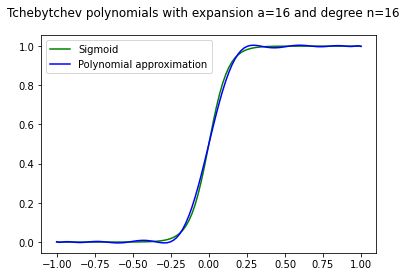

In [ ]:
from cryptotree.polynomials import plot_graph_function_approximation
import torch

dilatation_factor = 16
polynomial_degree = dilatation_factor
plot_graph_function_approximation(torch.sigmoid,dilatation_factor=dilatation_factor,polynomial_degree=polynomial_degree)

Here we will create two tree makers, one with sigmoid activation, the other one with tanh activation.

In [ ]:
sigmoid_tree_maker = SigmoidTreeMaker(use_polynomial=True,
                                  dilatation_factor=dilatation_factor, polynomial_degree=polynomial_degree)
tanh_tree_maker = TanhTreeMaker(use_polynomial=True,
                                  dilatation_factor=dilatation_factor, polynomial_degree=polynomial_degree)

Now we can create the trees by passing the sklearn tree to the tree maker.

In [ ]:
sigmoid_tree = sigmoid_tree_maker.make_tree(tree)
tanh_tree = tanh_tree_maker.make_tree(tree)

In [ ]:
with torch.no_grad():
    sigmoid_neural_pred = sigmoid_tree(torch.tensor(X_test).float()).argmax(dim=1).numpy()
    tanh_neural_pred = tanh_tree(torch.tensor(X_test).float()).argmax(dim=1).numpy()

pred = tree.predict(X_test)
print(f"Original accuracy : {(pred == y_test).mean()}")

print(f"Accuracy of sigmoid  : {(sigmoid_neural_pred == y_test).mean()}")
print(f"Accuracy of tanh : {(tanh_neural_pred == y_test).mean()}")

print(f"Match between sigmoid and original : {(sigmoid_neural_pred == pred).mean()}")
print(f"Match between tanh and original : {(tanh_neural_pred == pred).mean()}")

Original accuracy : 0.9736842105263158
Accuracy of sigmoid  : 0.9210526315789473
Accuracy of tanh : 0.9473684210526315
Match between sigmoid and original : 0.9210526315789473
Match between tanh and original : 0.9473684210526315


### Neural Random Forest

Neural Random Forest take as input a sklearn Random Forest. So we first need to train a regular sklearn Random Forest before turning it into a Neural Random Forest.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=4, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Now to create the Neural Random Forests, we simply need to pass the trees in the regular random forest, along with the chosen tree maker.

In [ ]:
sigmoid_neural_rf = NeuralRandomForest(rf.estimators_, sigmoid_tree_maker)
tanh_neural_rf = NeuralRandomForest(rf.estimators_, tanh_tree_maker)

In [ ]:
with torch.no_grad():
    sigmoid_neural_pred = sigmoid_neural_rf(torch.tensor(X_test).float()).argmax(dim=1).numpy()
    tanh_neural_pred = tanh_neural_rf(torch.tensor(X_test).float()).argmax(dim=1).numpy()

pred = rf.predict(X_test)
print(f"Original accuracy : {(pred == y_test).mean()}")

print(f"Accuracy of sigmoid  : {(sigmoid_neural_pred == y_test).mean()}")
print(f"Accuracy of tanh : {(tanh_neural_pred == y_test).mean()}")

print(f"Match between sigmoid and original : {(sigmoid_neural_pred == pred).mean()}")
print(f"Match between tanh and original : {(tanh_neural_pred == pred).mean()}")

Original accuracy : 0.9736842105263158
Accuracy of sigmoid  : 0.9736842105263158
Accuracy of tanh : 0.9736842105263158
Match between sigmoid and original : 1.0
Match between tanh and original : 1.0
